In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from __future__ import division
from __future__ import print_function
from datetime import datetime
import sys
import os
import random
from argparse import ArgumentParser


from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions.beta import Beta
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

from google.colab import drive
from random import sample
import random

drive.mount('/content/drive', force_remount=True)

# USE_GPU = True

# if USE_GPU:
#     device = '/device:GPU:0'
# else:
#     device = '/cpu:0'
# print('Using device: ', device)

sequence_num = 100
time_num = 3600
beta_param  = [0.1]
if len(beta_param) == 1:
      alpha_distribution = Beta(float(beta_param[0]), float(beta_param[0]))
      beta_distribution = Beta(float(beta_param[0]), float(beta_param[0]))
elif len(beta_param) == 2:
      alpha_distribution = Beta(float(beta_param[0]), float(beta_param[1]))
      beta_distribution = Beta(float(beta_param[0]), float(beta_param[0]))


print("Start")
print("Slide number: ", sequence_num)
#print("alpha_distribution: ",alpha_distribution.sample().item())
#print("beta_distribution: ",beta_distribution.sample().item())
fname = '/content/drive/MyDrive/Dinkle_ModelTraining/Bidi'+ str(sequence_num) +'/'

input_data_machine = '/content/drive/MyDrive/Dinkle_ModelTraining/2022_03_03_Data.xlsx'
input_data_rate = '/content/drive/MyDrive/Dinkle_ModelTraining/0309.xlsx'

data_machine = pd.read_excel(input_data_machine, usecols=["編號","frequency","Speed","Status"])
data_rate = pd.read_excel(input_data_rate)
#data_rate = data_rate[:569]
data_rate = data_rate[data_rate["料號"] == "0162B00100"]
data_machine = data_machine.dropna()
data_rate = data_rate.dropna()

print(data_machine.head())
print(data_rate.head())
print(data_machine.shape)
print(data_rate.shape)

Mounted at /content/drive
Start
Slide number:  100
                              編號  Speed  Status  frequency
0  2020081008:11_D-008_101180441  361.0     2.0   3.000000
1  2020081008:12_D-008_101180441  361.0     2.0   3.500000
2  2020081008:13_D-008_101180441  361.0     2.0   3.516667
3  2020081008:14_D-008_101180441  250.0     4.0   1.800000
4  2020081008:19_D-008_101180441  250.0     2.0   0.050000
                        產生檢驗單號的時間          料號  最大 - detail_5  最大 - detail_6  \
41  2020091508:53_D-001_101183683  0162B00100         3.2900           2.26   
42  2020091510:51_D-001_101183683  0162B00100         3.2820           2.25   
43  2020091513:16_D-001_101183683  0162B00100         3.2805           2.26   
44  2020091514:13_D-001_101183683  0162B00100         3.2840           2.24   
45  2020091516:51_D-001_101183683  0162B00100         3.2830           2.25   

    最大 - detail_7  最大 - detail_8  最大 - detail_9  最大 - detail_10  \
41         6.2370         2.7051         2.2000      

In [ ]:
"""
將瞬測儀和機台數據資料分包&配對
"""
data_machine.set_index("編號", inplace=True)
all_data_machineId = np.array(data_machine.index.drop_duplicates(keep='first').values)
data_machine.reset_index(inplace=True)

data_rate.set_index("產生檢驗單號的時間", inplace=True)
all_data_rateId = np.array(data_rate.index.drop_duplicates(keep='first').values)
data_rate.reset_index(inplace=True)

print(all_data_machineId.size)
print(all_data_rateId.size)


pkg_num = 0

for data_rateId in all_data_rateId:
  time_compare = time_num
  data_machineId_compare = 0
  for data_machineId in all_data_machineId:
    """
    完全相同
    """
    # if data_machineId == data_rateId:
    #   pkg_num += 1 
    #   globals()['x_'+str(pkg_num)] = data_machine[data_machine["編號"] == data_machineId]
    #   globals()['y_'+str(pkg_num)] = data_rate[data_rate["產生檢驗單號的時間"] == data_rateId]
    # else:
    """
    完全相同&時間誤差一小時內視為同包
    """
    machineId = data_machineId[14:29]  
    rateId = data_rateId[14:29]
    
    if rateId == machineId:
      time_machine = datetime.strptime(data_machineId[0:13], "%Y%m%d%H:%M")
      time_rate = datetime.strptime(data_rateId[0:13], "%Y%m%d%H:%M")
      time_diff = (time_rate - time_machine).total_seconds()

      if time_diff <= 1800 and time_diff >= 0 and time_diff < time_compare:
        data_machineId_compare = data_machineId
        time_compare = time_diff
          
  if data_machineId_compare != 0:
    pkg_num += 1 
    # print(data_machineId_compare)
    globals()['x_'+str(pkg_num)] = data_machine[data_machine["編號"] == data_machineId_compare]
    globals()['y_'+str(pkg_num)] = data_rate[data_rate["產生檢驗單號的時間"] == data_rateId]
    globals()['z_'+str(pkg_num)] = data_rate["料號"][data_rate["產生檢驗單號的時間"] == data_rateId]
    globals()['t_'+str(pkg_num)] = pd.Series([time_compare])

max_pkg_num = pkg_num
print("Total package number: ", max_pkg_num)

351091
566
Total package number:  477


In [ ]:
"""
機台資料往前取同機台工單sequence_num筆，計算筆數小於sequence_num筆包數
"""
usable_pkg = 0
lessthan = 0

for pkg_num in range(1, max_pkg_num+1):
  rateId = str(globals()['y_'+str(pkg_num)][["產生檢驗單號的時間"]].values)[17:32]
  machineIndex = int(globals()['x_'+str(pkg_num)].index[0])
  machineId = str(globals()['x_'+str(pkg_num)][["編號"]].values)[17:32]

  for num in range(machineIndex,0,-1):
    if num == machineIndex:
      globals()['x_sequence_'+str(pkg_num)] = data_machine.loc[[num]]
    else:
      if (str(data_machine["編號"][num])[14:31] == machineId) and (len(globals()['x_sequence_'+str(pkg_num)]) < sequence_num):
        globals()['x_sequence_'+str(pkg_num)] = pd.concat([globals()['x_sequence_'+str(pkg_num)], data_machine.loc[[num]]])

for pkg_num in range(1, max_pkg_num+1):
  if len(globals()['x_sequence_'+str(pkg_num)]) < sequence_num:
    lessthan += 1
  else:
    if usable_pkg == 0:
      first_pkg = pkg_num 
    usable_pkg += 1
  globals()['x_sequence_'+str(pkg_num)] = globals()['x_sequence_'+str(pkg_num)].drop(["編號"], axis=1)
  globals()['y_sequence_'+str(pkg_num)] = globals()['y_'+str(pkg_num)].drop(["產生檢驗單號的時間","料號"], axis=1)
  globals()['z_sequence_'+str(pkg_num)] = globals()['z_'+str(pkg_num)]
  globals()['t_sequence_'+str(pkg_num)] = globals()['t_'+str(pkg_num)]

print("Less than sequence_num data package: ",lessthan)
print("Usable package: ",usable_pkg)
print("First package number: ",first_pkg)

Less than sequence_num data package:  9
Usable package:  468
First package number:  1


In [ ]:
"""
one hot encoding
"""
for pkg_num in range(1, max_pkg_num+1):
  if len(globals()['x_sequence_'+str(pkg_num)]) < sequence_num:
    pass
  else:
    globals()['x_sequence_'+str(pkg_num)] = pd.get_dummies(globals()['x_sequence_'+str(pkg_num)]).values

print(globals()['x_sequence_'+str(first_pkg)].shape)  
print(globals()['y_sequence_'+str(first_pkg)].shape)
print(globals()['z_sequence_'+str(first_pkg)].shape)
print(globals()['t_sequence_'+str(first_pkg)].shape)

(100, 3)
(1, 26)
(1,)
(1,)


In [ ]:
"""
依序存進data & label
"""
for pkg_num in range(1, max_pkg_num+1):
  if len(globals()['x_sequence_'+str(pkg_num)]) < sequence_num:
    pass
  else:
    if pkg_num == first_pkg:
      data = pd.DataFrame(globals()['x_sequence_'+str(pkg_num)])   
      label = pd.DataFrame(globals()['y_sequence_'+str(pkg_num)])    
      partno = pd.DataFrame(globals()['z_sequence_'+str(pkg_num)])    
      timediff = pd.DataFrame(globals()['t_sequence_'+str(pkg_num)])
    else:
      data = pd.concat([data, pd.DataFrame(globals()['x_sequence_'+str(pkg_num)])])
      label = pd.concat([label, pd.DataFrame(globals()['y_sequence_'+str(pkg_num)])])
      partno = pd.concat([partno, pd.DataFrame(globals()['z_sequence_'+str(pkg_num)])])
      timediff = pd.concat([timediff, pd.DataFrame(globals()['t_sequence_'+str(pkg_num)])])

data = data.values
label = label.values
partno = partno.values
timediff = timediff.values

print(data.shape) 
print(label.shape) 
print(partno.shape) 
print(timediff.shape)

(46800, 3)
(468, 26)
(468, 1)
(468, 1)


In [ ]:
slide_size = 0
pkg_size = 0
data_temp = []
data_temp1 = []

for pkg_num in range(1, max_pkg_num+1):
  if len(globals()['x_sequence_'+str(pkg_num)]) < sequence_num:
    pass
  else: 
    data_temp.append(data[slide_size:(slide_size+sequence_num), 0:3])
    slide_size += sequence_num

data = np.array(data_temp)

print(data.shape)
print(label.shape)
print(partno.shape)
print(timediff.shape)

(468, 100, 3)
(468, 26)
(468, 1)
(468, 1)


In [ ]:
permutation=np.random.permutation(label.shape[0])
shuffled_data=data[permutation,:,:]
shuffled_label=label[permutation]
shuffled_partno=partno[permutation]
shuffled_timediff=timediff[permutation]

rate=0.7
X_train=shuffled_data[:int(shuffled_data.shape[0]*rate)]
Y_train=shuffled_label[:int(shuffled_label.shape[0]*rate)]
X_test=shuffled_data[int(shuffled_data.shape[0]*rate):]
Y_test=shuffled_label[int(shuffled_label.shape[0]*rate):]

Z_train=shuffled_partno[:int(shuffled_partno.shape[0]*rate)]
Z_test=shuffled_partno[int(shuffled_partno.shape[0]*rate):]
T_train=shuffled_timediff[:int(shuffled_timediff.shape[0]*rate)]
T_test=shuffled_timediff[int(shuffled_timediff.shape[0]*rate):]


print('X_train.shape',X_train.shape)
print('Y_train.shape',Y_train.shape)
print('X_test.shape',X_test.shape)
print('Y_test.shape',Y_test.shape)
print('Z_train.shape',Z_train.shape)
print('Z_test.shape',Z_test.shape)
print('T_train.shape',T_train.shape)
print('T_test.shape',T_test.shape)

X_train.shape (327, 100, 3)
Y_train.shape (327, 26)
X_test.shape (141, 100, 3)
Y_test.shape (141, 26)
Z_train.shape (327, 1)
Z_test.shape (141, 1)
T_train.shape (327, 1)
T_test.shape (141, 1)


In [ ]:
'''
permutation=np.random.permutation(Y_train.shape[0])
shuffled_data=X_train[permutation,:,:]
shuffled_label=Y_train[permutation]
shuffled_partno=Z_train[permutation]
#shuffled_timediff=T_train[permutation]

rate=0.8
X_train=shuffled_data[:int(shuffled_data.shape[0]*rate)]
Y_train=shuffled_label[:int(shuffled_label.shape[0]*rate)]
X_valid=shuffled_data[int(shuffled_data.shape[0]*rate):]
Y_valid=shuffled_label[int(shuffled_label.shape[0]*rate):]

Z_train=shuffled_partno[:int(shuffled_partno.shape[0]*rate)]
Z_valid=shuffled_partno[int(shuffled_partno.shape[0]*rate):]
#T_train=shuffled_timediff[:int(shuffled_timediff.shape[0]*rate)]
#T_valid=shuffled_timediff[int(shuffled_timediff.shape[0]*rate):]

print('X_train.shape',X_train.shape)
print('Y_train.shape',Y_train.shape)
print('X_valid.shape',X_valid.shape)
print('Y_valid.shape',Y_valid.shape)
print('X_test.shape',X_test.shape)
print('Y_test.shape',Y_test.shape)
print('Z_train.shape',Z_train.shape)
print('Z_valid.shape',Z_valid.shape)
#print('T_train.shape',T_train.shape)
#print('T_valid.shape',T_valid.shape)
'''

"\npermutation=np.random.permutation(Y_train.shape[0])\nshuffled_data=X_train[permutation,:,:]\nshuffled_label=Y_train[permutation]\nshuffled_partno=Z_train[permutation]\n#shuffled_timediff=T_train[permutation]\n\nrate=0.8\nX_train=shuffled_data[:int(shuffled_data.shape[0]*rate)]\nY_train=shuffled_label[:int(shuffled_label.shape[0]*rate)]\nX_valid=shuffled_data[int(shuffled_data.shape[0]*rate):]\nY_valid=shuffled_label[int(shuffled_label.shape[0]*rate):]\n\nZ_train=shuffled_partno[:int(shuffled_partno.shape[0]*rate)]\nZ_valid=shuffled_partno[int(shuffled_partno.shape[0]*rate):]\n#T_train=shuffled_timediff[:int(shuffled_timediff.shape[0]*rate)]\n#T_valid=shuffled_timediff[int(shuffled_timediff.shape[0]*rate):]\n\nprint('X_train.shape',X_train.shape)\nprint('Y_train.shape',Y_train.shape)\nprint('X_valid.shape',X_valid.shape)\nprint('Y_valid.shape',Y_valid.shape)\nprint('X_test.shape',X_test.shape)\nprint('Y_test.shape',Y_test.shape)\nprint('Z_train.shape',Z_train.shape)\nprint('Z_valid.s

In [ ]:
#normalization
def min_max(data):
  return (data-data.min())/(data.max()-data.min())

X_train = min_max(X_train)
#X_valid = min_max(X_valid)
X_test = min_max(X_test)

print('X_train.shape',X_train.shape)
#print('X_valid.shape',X_valid.shape)
print('X_test.shape',X_test.shape)

X_train.shape (327, 100, 3)
X_test.shape (141, 100, 3)


In [ ]:
#load or save data
np.save(fname + 'x_train_nonormol.npy', X_train)
# np.save(fname + 'x_valid_nonormol.npy', X_valid)
np.save(fname + 'y_train_nonormol.npy', Y_train)
# np.save(fname + 'Y_valid_nonormol.npy', Y_valid)
np.save(fname + 'x_test_nonormol.npy', X_test)
np.save(fname + 'y_test_nonormol.npy', Y_test)
# np.save(fname + 'Z_train_nonormol.npy', Z_train)
# np.save(fname + 'Z_valid_nonormol.npy', Z_valid)
# np.save(fname + 'Z_test_nonormol.npy', Z_test)
# np.save(fname + 't_train_nonormol.npy', T_train)

print("Done")

X_train = np.load(fname + 'x_train_nonormol.npy')
Y_train = np.load(fname + 'y_train_nonormol.npy')
X_test = np.load(fname + 'x_test_nonormol.npy')
Y_test = np.load(fname + 'y_test_nonormol.npy')
# Z_train = np.load(fname + 'Z_train_nonormol.npy',allow_pickle=True)
# Z_test = np.load(fname + 'Z_test_nonormol.npy',allow_pickle=True)



Done


In [ ]:
X_train, Y_train= torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32)
#X_valid, Y_valid= torch.tensor(X_valid, dtype=torch.float32), torch.tensor(Y_valid, dtype=torch.float32)
X_test, Y_test= torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


#Model Setting

In [ ]:
class BiLSTM_layer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional, batch_first=False):
        super(BiLSTM_layer, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=batch_first
        )

        self.fc = nn.Linear(hidden_size, 26)
        

    def forward(self, inputs):
        out, (h_n, c_n) = self.lstm(inputs, None)
        outputs = self.fc(torch.mean(h_n.squeeze(0), dim=0))

        return outputs


In [ ]:
class DataEncoder(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim=3,dropout=0.4):
    super(DataEncoder, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    
    self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                             nn.ReLU(),
                             nn.Dropout(dropout),
                             nn.Linear(hidden_dim, output_dim)
                            )
  def forward(self, x):
    return self.net(x)

class minmax_RuleEncoder(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim=3,dropout=0.4):
    super(minmax_RuleEncoder, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                             nn.ReLU(),
                             nn.Dropout(dropout),
                             nn.Linear(hidden_dim, output_dim)
                            )

  def forward(self, x):
    return self.net(x)

class outbound_RuleEncoder(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim=3,dropout=0.4):
    super(outbound_RuleEncoder, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                             nn.ReLU(),
                             nn.Dropout(dropout),
                             nn.Linear(hidden_dim, output_dim)
                            )

  def forward(self, x):
    return self.net(x)


In [ ]:
class Net(nn.Module):
  def __init__(self, input_dim, output_dim, minmax_rule_encoder, outbound_rule_encoder, data_encoder, hidden_dim=3, n_layers=1, merge='cat', skip=False, input_type='state'):
    super(Net, self).__init__()
    self.skip = skip
    self.input_type = input_type
    self.minmax_rule_encoder = minmax_rule_encoder
    self.outbound_rule_encoder = outbound_rule_encoder
    self.data_encoder = data_encoder
    self.n_layers = n_layers
    assert self.minmax_rule_encoder.input_dim ==  self.data_encoder.input_dim
    assert self.minmax_rule_encoder.output_dim ==  self.data_encoder.output_dim
    self.merge = merge
    if merge == 'cat':
      self.input_dim_decision_block = self.minmax_rule_encoder.output_dim * 3
    elif merge == 'add':
      self.input_dim_decision_block = self.minmax_rule_encoder.output_dim

    self.net = []
    for i in range(n_layers):
      if i == 0:
        in_dim = self.input_dim_decision_block
      else:
        in_dim = hidden_dim

      if i == n_layers-1:
        out_dim = output_dim
      else:
        out_dim = hidden_dim
      
      self.net.append(BiLSTM_layer(
              input_size=in_dim,
              hidden_size=64,
              num_layers=1,
              bidirectional=True,
              batch_first=True
          ))
    self.net = nn.Sequential(*self.net)

  def get_z(self, x, alpha=0.0, beta=0.0):
    minmax_rule_z = self.minmax_rule_encoder(x)
    outbound_rule_z = self.outbound_rule_encoder(x)
    data_z = self.data_encoder(x)

    if self.merge=='add':
      z = alpha * minmax_rule_z + beta * outbound_rule_z + (1-alpha-beta) * data_z    
    elif self.merge=='cat':
      z = torch.cat((alpha*minmax_rule_z , beta*outbound_rule_z , (1-alpha-beta)*data_z), dim=-1)   

    return z

  def forward(self, x, alpha=0.0, beta=0.0):
    minmax_rule_z = self.minmax_rule_encoder(x)
    outbound_rule_z = self.outbound_rule_encoder(x)
    data_z = self.data_encoder(x)

    if self.merge=='add':
      z = alpha*minmax_rule_z + beta*outbound_rule_z + (1-alpha-beta)*data_z   
    elif self.merge=='cat':
      z = torch.cat((alpha*minmax_rule_z , beta*outbound_rule_z , (1-alpha-beta)*data_z), dim=-1)  
    else:
      print(self.merge)
  
    if self.skip:
      if self.input_type == 'seq':
        return self.net(z) + x[:,-1,:]
      else:
        return self.net(z) + x    
    else:
      return self.net(z) 
      
      try:
        return self.net(z)   
      except:
        print(type(z))
        print(z.shape)

class DataonlyNet(nn.Module):
  def __init__(self, input_dim, output_dim, data_encoder, hidden_dim=4, n_layers=2, skip=False, input_type='state'):
    super(DataonlyNet, self).__init__()
    self.skip = skip
    self.input_type = input_type
    self.data_encoder = data_encoder
    self.n_layers = n_layers
    self.input_dim_decision_block = self.data_encoder.output_dim

    self.net = []
    for i in range(n_layers):
      if i == 0:
        in_dim = self.input_dim_decision_block
      else:
        in_dim = hidden_dim

      if i == n_layers-1:
        out_dim = output_dim
      else:
        out_dim = hidden_dim

      self.net.append(BiLSTM_layer(
            input_size=in_dim,
            hidden_size=64,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        ))
      
    self.net = nn.Sequential(*self.net)

  def get_z(self, x, alpha=0.0):
    data_z = self.data_encoder(x)

    return data_z

  def forward(self, x, alpha=0.0):
    data_z = self.data_encoder(x)
    z = data_z

    if self.skip:
      if self.input_type == 'seq':
        return self.net(z) + x[:,-1,:]
      else:
        return self.net(z) + x    
    else:
      return self.net(z)    

In [ ]:
merge = 'cat'

input_dim =3
input_dim_encoder=3
output_dim_encoder=2
hidden_dim_encoder=64
hidden_dim_db=64
output_dim_encoder = output_dim_encoder
hidden_dim_encoder = hidden_dim_encoder
hidden_dim_db =hidden_dim_db
output_dim = 26
n_layers=1
use_type=''

'''做CV時再call model，因為model沒更新
outbound_rule_encoder = outbound_RuleEncoder(input_dim, output_dim_encoder, hidden_dim_encoder,dropout=0.2)
minmax_rule_encoder = minmax_RuleEncoder(input_dim, output_dim_encoder, hidden_dim_encoder,dropout=0.2)
data_encoder = DataEncoder(input_dim, output_dim_encoder, hidden_dim_encoder,dropout=0.2)
if use_type == 'no_rule':
  model = DataonlyNet(input_dim, output_dim, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers)
else:
  model = Net(input_dim, output_dim, minmax_rule_encoder, outbound_rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, merge=merge)


#optimizer = optim.RMSprop(model.parameters(), lr=0.001,  eps=1e-08, weight_decay=0, momentum=0, centered=False)
optimizer = optim.Adam(model.parameters(), lr=0.01)
''' 
 

def custom_mse(y_true, y_pred, alpha, beta):
    alpha_loss=alpha
    beta_loss=beta
    
    loss_task = nn.MSELoss()(y_true, y_pred)
    #loss_rule=  K.relu(y_pred[:,0] - 3.35)+K.relu(3.30 - y_pred[:,0])+K.relu(y_pred[:,1] - 2.3)+K.relu(2.2 - y_pred[:,1])+K.relu(y_pred[:,2] - 6.2)+K.relu(6.14 - y_pred[:,2])+K.relu(y_pred[:,3] - 2.77)+K.relu(2.63 - y_pred[:,3])+K.relu(y_pred[:,4] - 2.3)+K.relu(2.1 - y_pred[:,4])+K.relu(y_pred[:,5] - 3.37)+K.relu(3.23 - y_pred[:,5])+K.relu(y_pred[:,6] - 2.54)+K.relu(2.34 - y_pred[:,6])+K.relu(y_pred[:,7] - 0.42)+K.relu(0.38 - y_pred[:,7])+K.relu(y_pred[:,8] - 0.63)+K.relu(0.53 - y_pred[:,8])+K.relu(y_pred[:,9] - 0.63)+K.relu(0.53 - y_pred[:,9])+K.relu(y_pred[:,10] - 0.63)+K.relu(0.53 - y_pred[:,10])+K.relu(y_pred[:,11] - 0.63)+K.relu(0.53 - y_pred[:,11])+K.relu(y_pred[:,12] - 0.63)+K.relu(0.53 - y_pred[:,12])+K.relu(y_pred[:,13] - 3.35)+K.relu(3.30 - y_pred[:,13])+K.relu(y_pred[:,14] - 2.3)+K.relu(2.2 - y_pred[:,14])+K.relu(y_pred[:,15] - 6.2)+K.relu(6.14 - y_pred[:,15])+K.relu(y_pred[:,16] - 2.77)+K.relu(2.63 - y_pred[:,16])+K.relu(y_pred[:,17] - 2.3)+K.relu(2.1 - y_pred[:,17])+K.relu(y_pred[:,18] - 3.37)+K.relu(3.23 - y_pred[:,18])+K.relu(y_pred[:,19] - 2.54)+K.relu(2.34 - y_pred[:,19])+K.relu(y_pred[:,20] - 0.42)+K.relu(0.38 - y_pred[:,20])+K.relu(y_pred[:,21] - 0.63)+K.relu(0.53 - y_pred[:,21])+K.relu(y_pred[:,22] - 0.63)+K.relu(0.53 - y_pred[:,22])+K.relu(y_pred[:,23] - 0.63)+K.relu(0.53 - y_pred[:,23])+K.relu(y_pred[:,24] - 0.63)+K.relu(0.53 - y_pred[:,24])+K.relu(y_pred[:,25] - 0.63)+K.relu(0.53 - y_pred[:,25])
    loss_rule_minmax= F.relu(y_pred[:,13] - y_pred[:,0])+F.relu(y_pred[:,14] - y_pred[:,1])+F.relu(y_pred[:,15] - y_pred[:,2])+F.relu(y_pred[:,16] - y_pred[:,3])+F.relu(y_pred[:,17] - y_pred[:,4])+F.relu(y_pred[:,18] - y_pred[:,5])+F.relu(y_pred[:,19] - y_pred[:,6])+F.relu(y_pred[:,20] - y_pred[:,7])+F.relu(y_pred[:,21] - y_pred[:,8])+F.relu(y_pred[:,22] - y_pred[:,9])+F.relu(y_pred[:,23] - y_pred[:,10])+F.relu(y_pred[:,24] - y_pred[:,11])+F.relu(y_pred[:,25] - y_pred[:,12])
    loss_rule_outbound=F.relu((y_true[:,0] - 3.35)*(3.35-y_pred[:,0]))+F.relu((y_true[:,1] - 2.3)*(2.3-y_pred[:,1]))+F.relu((y_true[:,2] - 6.3)*(6.3-y_pred[:,2]))+F.relu((y_true[:,3] - 2.77)*(2.77-y_pred[:,3]))+F.relu((y_true[:,4] - 2.3)*(2.3-y_pred[:,4]))+F.relu((y_true[:,5] - 3.37)*(3.37-y_pred[:,5]))+F.relu((y_true[:,6] - 2.54)*(2.54-y_pred[:,6]))+F.relu((y_true[:,7] - 0.42)*(0.42-y_pred[:,7]))+F.relu((y_true[:,8] - 0.63)*(0.63-y_pred[:,8]))+F.relu((y_true[:,9] - 0.63)*(0.63-y_pred[:,9]))+F.relu((y_true[:,10] - 0.63)*(0.63-y_pred[:,10]))+F.relu((y_true[:,11] - 0.63)*(0.63-y_pred[:,11]))+F.relu((y_true[:,12] - 0.63)*(0.63-y_pred[:,12]))+F.relu((y_true[:,13] - 3.25)*(3.25-y_pred[:,13]))+F.relu((y_true[:,14] - 2.2)*(2.2-y_pred[:,14]))+F.relu((y_true[:,15] - 6.14)*(6.14-y_pred[:,15]))+F.relu((y_true[:,16] - 2.63)*(2.63-y_pred[:,16]))+F.relu((y_true[:,17] - 2.1)*(2.1-y_pred[:,17]))+F.relu((y_true[:,18] - 3.23)*(3.23-y_pred[:,18]))+F.relu((y_true[:,19] - 2.34)*(2.34-y_pred[:,19]))+F.relu((y_true[:,20] - 2.38)*(2.38-y_pred[:,20]))+F.relu((y_true[:,21] - 0.53)*(0.53-y_pred[:,21]))+F.relu((y_true[:,22] - 0.53)*(0.53-y_pred[:,22]))+F.relu((y_true[:,23] - 0.53)*(0.53-y_pred[:,23]))+F.relu((y_true[:,24] - 0.53)*(0.53-y_pred[:,24]))+F.relu((y_true[:,25] - 0.53)*(0.53-y_pred[:,25]))
    loss_rule_outbound=loss_rule_outbound*10
   

    #print('alpha_loss',alpha_loss)
    #print('beta_loss',beta_loss)
    loss= alpha_loss*loss_rule_minmax + beta_loss*loss_rule_outbound + (1-beta_loss-alpha_loss)*loss_task

    return loss





In [ ]:
best_val_loss = float('inf')
counter_early_stopping = 1


#Model Training & Validation

In [ ]:
batch_size=16
k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)

#train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
#validation_loader = DataLoader(TensorDataset(X_valid, Y_valid), batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=batch_size, shuffle=True)

In [ ]:
def train_epoch(model,dataloader,optimizer):
    loss_int = 0.0
    model.train()
    for batch_train_x, batch_train_y in dataloader:
      #batch_train_x=torch.reshape(batch_train_x, (-1, 300))
      optimizer.zero_grad()
      alpha = alpha_distribution.sample().item()
      #alpha=0
      #beta=0
      beta = beta_distribution.sample().item()
      
      if (alpha+beta)>=1:
        alpha=alpha/2
        beta=beta/2
      
      output= model(batch_train_x, alpha=alpha, beta=beta)      
      loss=custom_mse(batch_train_y, output, alpha, beta)

      loss.sum().backward() #Back Propagation
      optimizer.step() #Gardient Descent

      loss_int += loss.sum().item()

    return loss_int, alpha, beta

  
def valid_epoch(model,dataloader,alpha,beta):
    val_loss_int = 0.0
    model.eval()
    with torch.no_grad():

      for val_x, val_y in dataloader: 
        output= model(val_x,alpha=0.0,beta=0.0)
        val_loss=custom_mse(val_y, output, alpha, beta)
        val_loss_int += val_loss.sum().item()

    return val_loss_int

In [ ]:
from tqdm.notebook import tqdm
from copy import deepcopy
epochs=20 #測試用20 實際訓練為1000
early_stopping_thld=200
#use_type == 'no_rule'
loss_list=[]
val_loss_list=[]

model_type='test'
saved_filename = 'rule_{}.pt'.format(model_type)
saved_filename =  os.path.join(fname , saved_filename)

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(X_train)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=batch_size, sampler=val_sampler)

    #each model will train a new model
    outbound_rule_encoder = outbound_RuleEncoder(input_dim, output_dim_encoder, hidden_dim_encoder,dropout=0.2)
    minmax_rule_encoder = minmax_RuleEncoder(input_dim, output_dim_encoder, hidden_dim_encoder,dropout=0.2)
    data_encoder = DataEncoder(input_dim, output_dim_encoder, hidden_dim_encoder,dropout=0.2)
    
    model = Net(input_dim, output_dim, minmax_rule_encoder, outbound_rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, merge=merge)
    optimizer = optim.Adam(model.parameters(), lr=0.01) 


    fold_loss_list=[]
    fold_val_loss_list=[]

    for epoch in tqdm(range(1, epochs+1)):
        train_loss, alpha, beta = train_epoch(model,train_loader,optimizer)
        val_loss = valid_epoch(model,val_loader,alpha,beta)

        train_loss = train_loss / len(train_loader.sampler)
        val_loss = val_loss / len(val_loader.sampler)

        
        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Val Loss:{:.3f} ".format(epoch,epochs,train_loss,val_loss))
                                                                                                             
        fold_val_loss_list.append(val_loss)
        fold_loss_list.append(train_loss)
    
    val_loss_list.append(fold_val_loss_list)
    loss_list.append(fold_loss_list)
  
  
    # if val_loss < best_val_loss:
    #       counter_early_stopping = 1
    #       best_val_loss = val_loss
    #       best_model_state_dict = deepcopy(model.state_dict())
    #       print('Epoch: {} Loss: {:.6f}  val_loss: {:.6f}  best model is updated!! '.format(epoch, loss_int,val_loss_int))
    #       '''
    #       torch.save({
    #             'epoch': epoch,
    #             'model_state_dict':model.state_dict(),
    #             'optimizer_state_dict': optimizer.state_dict(),
    #             'loss': best_val_loss
    #           }, saved_filename)
    #       '''
    #       torch.save(model,saved_filename)
          
    # else:
    #       print('Epoch: {} Loss: {:.6f}  val_loss: {:.6f}  '.format(epoch, loss_int,val_loss_int))
  
    #       if counter_early_stopping >= early_stopping_thld:
    #         break
    #       else:
    #         counter_early_stopping += 1
  
    
 

Fold 1


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:1/20 AVG Training Loss:4.837 AVG Val Loss:1.589 
Epoch:2/20 AVG Training Loss:0.998 AVG Val Loss:0.231 
Epoch:3/20 AVG Training Loss:0.536 AVG Val Loss:0.410 
Epoch:4/20 AVG Training Loss:0.763 AVG Val Loss:0.129 
Epoch:5/20 AVG Training Loss:0.361 AVG Val Loss:0.085 
Epoch:6/20 AVG Training Loss:0.206 AVG Val Loss:0.189 
Epoch:7/20 AVG Training Loss:0.153 AVG Val Loss:0.512 
Epoch:8/20 AVG Training Loss:0.242 AVG Val Loss:1.127 
Epoch:9/20 AVG Training Loss:0.144 AVG Val Loss:0.578 
Epoch:10/20 AVG Training Loss:0.153 AVG Val Loss:0.157 
Epoch:11/20 AVG Training Loss:0.085 AVG Val Loss:0.344 
Epoch:12/20 AVG Training Loss:0.192 AVG Val Loss:0.668 
Epoch:13/20 AVG Training Loss:0.250 AVG Val Loss:0.435 
Epoch:14/20 AVG Training Loss:0.202 AVG Val Loss:0.612 
Epoch:15/20 AVG Training Loss:0.152 AVG Val Loss:0.551 
Epoch:16/20 AVG Training Loss:0.108 AVG Val Loss:0.500 
Epoch:17/20 AVG Training Loss:0.118 AVG Val Loss:0.143 
Epoch:18/20 AVG Training Loss:0.102 AVG Val Loss:0.108 
E

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:1/20 AVG Training Loss:4.523 AVG Val Loss:2.133 
Epoch:2/20 AVG Training Loss:0.917 AVG Val Loss:0.262 
Epoch:3/20 AVG Training Loss:0.464 AVG Val Loss:0.659 
Epoch:4/20 AVG Training Loss:0.189 AVG Val Loss:0.144 
Epoch:5/20 AVG Training Loss:0.236 AVG Val Loss:0.218 
Epoch:6/20 AVG Training Loss:0.290 AVG Val Loss:0.189 
Epoch:7/20 AVG Training Loss:0.159 AVG Val Loss:0.613 
Epoch:8/20 AVG Training Loss:0.142 AVG Val Loss:0.373 
Epoch:9/20 AVG Training Loss:0.223 AVG Val Loss:0.104 
Epoch:10/20 AVG Training Loss:0.207 AVG Val Loss:0.533 
Epoch:11/20 AVG Training Loss:0.125 AVG Val Loss:1.576 
Epoch:12/20 AVG Training Loss:0.304 AVG Val Loss:0.457 
Epoch:13/20 AVG Training Loss:0.154 AVG Val Loss:0.029 
Epoch:14/20 AVG Training Loss:0.201 AVG Val Loss:0.306 
Epoch:15/20 AVG Training Loss:0.163 AVG Val Loss:0.312 
Epoch:16/20 AVG Training Loss:0.085 AVG Val Loss:0.900 
Epoch:17/20 AVG Training Loss:0.136 AVG Val Loss:0.368 
Epoch:18/20 AVG Training Loss:0.223 AVG Val Loss:0.396 
E

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:1/20 AVG Training Loss:3.617 AVG Val Loss:0.439 
Epoch:2/20 AVG Training Loss:0.592 AVG Val Loss:0.584 
Epoch:3/20 AVG Training Loss:0.283 AVG Val Loss:0.395 
Epoch:4/20 AVG Training Loss:0.366 AVG Val Loss:0.540 
Epoch:5/20 AVG Training Loss:0.237 AVG Val Loss:0.048 
Epoch:6/20 AVG Training Loss:0.202 AVG Val Loss:0.035 
Epoch:7/20 AVG Training Loss:0.185 AVG Val Loss:0.528 
Epoch:8/20 AVG Training Loss:0.104 AVG Val Loss:0.217 
Epoch:9/20 AVG Training Loss:0.297 AVG Val Loss:0.282 
Epoch:10/20 AVG Training Loss:0.282 AVG Val Loss:0.645 
Epoch:11/20 AVG Training Loss:0.298 AVG Val Loss:0.020 
Epoch:12/20 AVG Training Loss:0.145 AVG Val Loss:0.814 
Epoch:13/20 AVG Training Loss:0.187 AVG Val Loss:0.502 
Epoch:14/20 AVG Training Loss:0.244 AVG Val Loss:0.450 
Epoch:15/20 AVG Training Loss:0.404 AVG Val Loss:1.069 
Epoch:16/20 AVG Training Loss:0.192 AVG Val Loss:0.532 
Epoch:17/20 AVG Training Loss:0.155 AVG Val Loss:0.015 
Epoch:18/20 AVG Training Loss:0.088 AVG Val Loss:0.017 
E

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:1/20 AVG Training Loss:4.307 AVG Val Loss:0.595 
Epoch:2/20 AVG Training Loss:0.917 AVG Val Loss:1.666 
Epoch:3/20 AVG Training Loss:0.663 AVG Val Loss:0.654 
Epoch:4/20 AVG Training Loss:0.263 AVG Val Loss:0.736 
Epoch:5/20 AVG Training Loss:0.206 AVG Val Loss:0.769 
Epoch:6/20 AVG Training Loss:0.272 AVG Val Loss:0.523 
Epoch:7/20 AVG Training Loss:0.338 AVG Val Loss:0.241 
Epoch:8/20 AVG Training Loss:0.172 AVG Val Loss:1.207 
Epoch:9/20 AVG Training Loss:0.181 AVG Val Loss:0.168 
Epoch:10/20 AVG Training Loss:0.164 AVG Val Loss:0.074 
Epoch:11/20 AVG Training Loss:0.249 AVG Val Loss:0.721 
Epoch:12/20 AVG Training Loss:0.196 AVG Val Loss:0.075 
Epoch:13/20 AVG Training Loss:0.207 AVG Val Loss:0.169 
Epoch:14/20 AVG Training Loss:0.311 AVG Val Loss:0.837 
Epoch:15/20 AVG Training Loss:0.211 AVG Val Loss:0.033 
Epoch:16/20 AVG Training Loss:0.136 AVG Val Loss:0.249 
Epoch:17/20 AVG Training Loss:0.051 AVG Val Loss:0.017 
Epoch:18/20 AVG Training Loss:0.187 AVG Val Loss:0.086 
E

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:1/20 AVG Training Loss:4.721 AVG Val Loss:3.755 
Epoch:2/20 AVG Training Loss:1.522 AVG Val Loss:1.037 
Epoch:3/20 AVG Training Loss:1.198 AVG Val Loss:0.666 
Epoch:4/20 AVG Training Loss:0.456 AVG Val Loss:0.033 
Epoch:5/20 AVG Training Loss:0.247 AVG Val Loss:0.105 
Epoch:6/20 AVG Training Loss:0.343 AVG Val Loss:0.750 
Epoch:7/20 AVG Training Loss:0.183 AVG Val Loss:0.317 
Epoch:8/20 AVG Training Loss:0.073 AVG Val Loss:0.090 
Epoch:9/20 AVG Training Loss:0.059 AVG Val Loss:0.288 
Epoch:10/20 AVG Training Loss:0.126 AVG Val Loss:0.359 
Epoch:11/20 AVG Training Loss:0.096 AVG Val Loss:0.089 
Epoch:12/20 AVG Training Loss:0.112 AVG Val Loss:0.116 
Epoch:13/20 AVG Training Loss:0.088 AVG Val Loss:0.470 
Epoch:14/20 AVG Training Loss:0.199 AVG Val Loss:0.320 
Epoch:15/20 AVG Training Loss:0.364 AVG Val Loss:0.578 
Epoch:16/20 AVG Training Loss:0.287 AVG Val Loss:0.403 
Epoch:17/20 AVG Training Loss:0.167 AVG Val Loss:0.199 
Epoch:18/20 AVG Training Loss:0.118 AVG Val Loss:0.071 
E

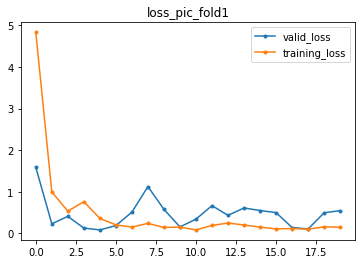

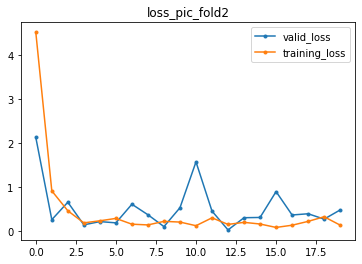

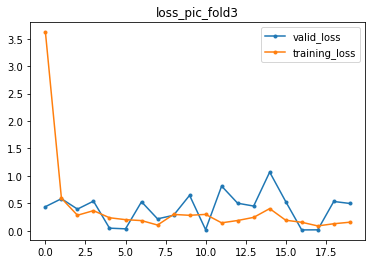

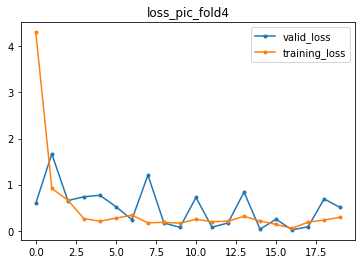

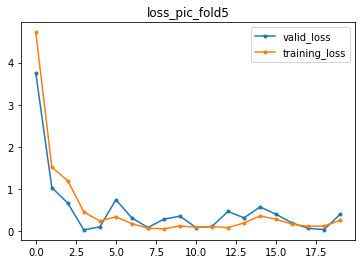

In [ ]:
for i in range(0,len(loss_list)):
  x1 = range(0,epochs) 
  y1 = loss_list[i]
  y2 = val_loss_list[i]
  plt.plot(x1, y2, '.-',label='valid_loss')
  plt.plot(x1, y1, '.-',label='training_loss')
  plt.legend(loc='upper right')
  plt.title('loss_pic'+'_fold'+str(i+1))
  plt.show()

# x1 = range(1,k+1) 
# y1 = np.mean(loss_list[0]),np.mean(loss_list[1]),np.mean(loss_list[2]),np.mean(loss_list[3]),np.mean(loss_list[4])
# y2 = np.mean(val_loss_list[0]),np.mean(val_loss_list[1]),np.mean(val_loss_list[2]),np.mean(val_loss_list[3]),np.mean(val_loss_list[4])
# plt.plot(x1, y1, '.-',label='training_loss_avg')
# plt.plot(x1, y2, '.-',label='valid_loss_avg')
# plt.legend(loc='upper right')
# plt.title('loss_pic_avg')
# plt.show()


In [ ]:
"""
規格判斷 
"""
def measure_std(data):
  measure = []
  for data_num in range(len(data)):
    #partNo = Z_test[data_num]
    partNo = "0162B00100"
    #partNo = "0162B00200"
    if partNo == "0162B00100":
      max_std = [3.35, 2.3, 6.3, 2.77, 2.3, 3.37, 2.54, 0.42, 0.63, 0.63, 0.63, 0.63, 0.63]
      min_std = [3.25, 2.20, 6.14, 2.63, 2.10, 3.23, 2.34, 0.38, 0.53, 0.53, 0.53, 0.53, 0.53]

    elif partNo == "0162B00200":
      max_std = [3.35, 2.3, 6.3, 2.77, 3.37, 2.54, 0.42, 2.3, 0.63, 0.63, 0.63, 0.63, 0.63]
      min_std = [3.25, 2.20, 6.14, 2.63, 3.23, 2.34, 0.38, 2.10, 0.53, 0.53, 0.53, 0.53, 0.53]

    elif partNo == "0162B00200-1":
      max_std = [2.28, 2.28, 2.28, 2.28, 3.35, 3.35, 2.29, 2.29, 10.48, 14.50, 1.19, 1.36, 136.50]
      min_std = [2.12, 2.12, 2.12, 2.12, 3.25, 3.25, 2.21, 2.21, 10.32, 14.10, 1.13, 1.20, 133.50]

    elif partNo == "0162B01100":
      max_std = [3.35, 2.30, 6.30, 2.77, 3.37, 2.54, 0.42, 2.30, 0.63, 0.63, 0.63, 0.63, 0.63]
      min_std = [3.25, 2.20, 6.14, 2.63, 3.23, 2.34, 0.38, 2.10, 0.53, 0.53, 0.53, 0.53, 0.53]
    
    elif partNo == "0162B01100-1":
      max_std = [2.28, 2.28, 2.28, 2.28, 3.35, 3.35, 2.29, 2.29, 10.48, 14.50, 1.19, 1.36, 136.50]
      min_std = [2.12, 2.12, 2.12, 2.12, 3.25, 3.25, 2.21, 2.21, 10.32, 14.10, 1.13, 1.20, 133.50]

    else:
      return "Error"
    wrong = False
    for detail_num in range(13):
    
      if data[data_num][detail_num] > max_std[detail_num] or data[data_num][detail_num] < min_std[detail_num]:
        wrong = True
        
      elif data[data_num][detail_num+13] < min_std[detail_num] or data[data_num][detail_num+13] > max_std[detail_num]:
        wrong = True
        
        
      else:
        pass
    
    if wrong == True:
      measure.append(0) # notok
    else:
      measure.append(1) # ok

  return measure
      

In [53]:
model_eval=torch.load(saved_filename) #做完CV要存model

FileNotFoundError: ignored

In [ ]:
#Xtest = X_test.reshape(-1, sequence_num*3).numpy()
pred = pred.numpy()
df = pd.DataFrame()
p_df = pd.DataFrame(pred)

for i in range(26):
  df['pred'+str(i+1)] = p_df[i]

measure_pred = np.array(measure_std(pred))

df['measure_pred'] = measure_pred

#df.to_csv(fname +"/testall_0419(30000).csv", header=True, index=True) 
print(df.head(10))
print(df.tail(10))

In [ ]:
df = pd.DataFrame()
partNo = "0162B00100"
#partNo = "0162B00200"

#test
outbound_rule_encoder = outbound_RuleEncoder(input_dim, output_dim_encoder, hidden_dim_encoder)
minmax_rule_encoder = minmax_RuleEncoder(input_dim, output_dim_encoder, hidden_dim_encoder)
data_encoder = DataEncoder(input_dim, output_dim_encoder, hidden_dim_encoder) 
'''

model_eval = Net(input_dim, output_dim, minmax_rule_encoder, outbound_rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, merge=merge)

checkpoint = torch.load(saved_filename)
model_eval.load_state_dict(checkpoint['model_state_dict'])
print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))
'''
model_eval=torch.load(saved_filename)

test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=batch_size, shuffle=True)

y_pred_list=[]
y_true_list=[]
pred_arr=[]
true_arr=[]
test_loss_arr=[]
y2=[]
count=0
model_eval.eval()
with torch.no_grad():
    for te_x, te_y in test_loader:
      #test different combination of alpha and beta
      output = model_eval(te_x, alpha=0.4,beta=0.6)
      y_true = te_y.numpy()
      y_true_list.append(y_true)
      #print(output)
    
      y_pred = output.numpy()
      y_pred_list.append(y_pred)
      #print(len(y_pred))

      test_loss=custom_mse(te_y, output, alpha=0.0, beta=0.0)
      test_loss_int=test_loss.sum().item()
      test_loss_arr.append(test_loss_int)

     
      for k in range(len(y_pred)):     
          pred_arr.append(y_pred[k])
          true_arr.append(y_true[k])

#print(len(test_loss_arr))
y2.append(sum(test_loss_arr)/len(test_loss_arr))
print("test_loss: ",y2)
y2=[]
df = pd.DataFrame()

y_df = pd.DataFrame(true_arr)
p_df = pd.DataFrame(pred_arr)

for i in range(26):
  df['true'+str(i+1)] = y_df[i]
  df['pred'+str(i+1)] = p_df[i]

measure_true = np.array(measure_std(true_arr))
measure_pred = np.array(measure_std(pred_arr))

df['measure_true'] = measure_true
df['measure_pred'] = measure_pred   

#df.to_csv(fname +"0419nonormal!!!.csv", header=True, index=True) 

#print(df.head(10))
#print(df.tail(10))
#print(df.shape)
#print('y_true shape',type(y_true))
#print('y_pred shape',type(y_pred))
count=0
for i in range(len(pred_arr)):
  if df.loc[i,'measure_true']==0:
    if df.loc[i,'measure_pred']==0:
      count+=1
  else:
    if df.loc[i,'measure_pred']==1:
      if df.loc[i,'measure_pred']==1:
        count+=1
print('acc: ',count/141)


In [ ]:
from pandas.core.common import temp_setattr
test_measure_ok=0
pred_measure_ok=0
test_measure_ok_arr=[]
pred_measure_ok_arr=[]
X_test_correct=[]
X_test_wrong=[]

for test_num in range(len(X_test)):
  if df.loc[test_num,'measure_true']==1:
    test_measure_ok +=1
    test_measure_ok_arr.append(1)
    if df.loc[test_num,'measure_pred']==1:
      pred_measure_ok +=1
      pred_measure_ok_arr.append(1)
      X_test_correct.append(X_test[test_num])
    else:
      pred_measure_ok_arr.append(0)
      X_test_wrong.append(X_test[test_num])
     
  else:  #measure_true==0
    test_measure_ok_arr.append(0)
    if df.loc[test_num,'measure_pred']==1:
      pred_measure_ok_arr.append(1)
      X_test_wrong.append(X_test[test_num])

    else:
      pred_measure_ok_arr.append(0)
      X_test_correct.append(X_test[test_num])


print("實際值良品：",test_measure_ok,"個")
print("實際值良品 & 預測值良品：",pred_measure_ok,"個")
print("良品預測準確率：",pred_measure_ok/test_measure_ok)

In [ ]:
np.save(fname + 'x_test_correct_nonormal0420.npy', X_test_correct)
np.save(fname + 'x_test_wrong_nonormal0420.npy', X_test_wrong)
print(len(X_test_correct))
print(len(X_test_wrong))

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=test_measure_ok_arr, y_pred=pred_measure_ok_arr)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [ ]:
"""
true & pred 散布圖
"""

data_plt = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true1","pred1"])
data_plt2 = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true14","pred14"])
plt.style.use("ggplot")
#plt.style.use('seaborn-ticks')
plt.figure(figsize=(6,6)) 
plt.scatter('true1', 'pred1', data=data_plt, s = 6,color='red',label='max')
plt.scatter('true14', 'pred14', data=data_plt2, s = 6,color='green',label='min')
plt.xlabel('TRUE')
plt.ylabel('PRED')
plt.xlim(3.2,3.4)
plt.ylim(3.2,3.4)
plt.plot([-1, 11], [-1,11], ls="--", c="#AAAFFF")
plt.plot([0, 4], [3.35,3.35], ls="--", c="pink",label='max_std')
plt.plot([3.35, 3.35], [0,4], ls="--", c="pink")
plt.plot([0, 4], [3.25,3.25], ls="--", c="yellow",label='min_std')
plt.plot([3.25, 3.25], [0,4], ls="--", c="yellow")
plt.legend(loc="best")
#plt.regplot(x=data_plt['TRUE'], y=data_plt['pred'])
plt.title('detail 1')
plt.show()
print(len(data_plt))


In [ ]:
"""
true & pred 散布圖
"""

data_plt = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true2","pred2"])
data_plt2 = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true15","pred15"])
plt.style.use("ggplot")
#plt.style.use('seaborn-ticks')
plt.figure(figsize=(6,6)) 
plt.scatter('true2', 'pred2', data=data_plt, s = 6,color='red',label='max')
plt.scatter('true15', 'pred15', data=data_plt2, s = 6,color='green',label='min')
plt.xlabel('TRUE')
plt.ylabel('PRED')
plt.xlim(2.1,2.4)
plt.ylim(2.1,2.4)
plt.plot([-1, 11], [-1,11], ls="--", c="#AAAFFF")
plt.plot([0, 4], [2.3,2.3], ls="--", c="pink",label='max_std')
plt.plot([2.3, 2.3], [0,4], ls="--", c="pink")
plt.plot([0, 4], [2.2,2.2], ls="--", c="yellow",label='min_std')
plt.plot([2.2, 2.2], [0,4], ls="--", c="yellow")
plt.legend(loc="best")
#plt.regplot(x=data_plt['TRUE'], y=data_plt['pred'])
plt.title('detail 2')
plt.show()


In [ ]:
"""
true & pred 散布圖
"""

data_plt = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true3","pred3"])
data_plt2 = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true16","pred16"])
plt.style.use("ggplot")
#plt.style.use('seaborn-ticks')
plt.figure(figsize=(6,6)) 
plt.scatter('true3', 'pred3', data=data_plt, s = 6,color='red',label='max')
plt.scatter('true16', 'pred16', data=data_plt2, s = 6,color='green',label='min')
plt.xlabel('TRUE')
plt.ylabel('PRED')
plt.xlim(6.0,6.4)
plt.ylim(6.0,6.4)
plt.plot([-1, 11], [-1,11], ls="--", c="#AAAFFF")
plt.plot([4, 8], [6.3,6.3], ls="--", c="pink",label='max_std')
plt.plot([6.3, 6.3], [4,8], ls="--", c="pink")
plt.plot([4, 8], [6.14,6.14], ls="--", c="yellow",label='min_std')
plt.plot([6.14, 6.14], [4,8], ls="--", c="yellow")
plt.legend(loc="best")
#plt.regplot(x=data_plt['TRUE'], y=data_plt['pred'])
plt.title('detail 3')
plt.show()


In [ ]:
"""
true & pred 散布圖
"""

data_plt = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true4","pred4"])
data_plt2 = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true17","pred17"])
plt.style.use("ggplot")
#plt.style.use('seaborn-ticks')
plt.figure(figsize=(6,6)) 
plt.scatter('true4', 'pred4', data=data_plt, s = 6,color='red',label='max')
plt.scatter('true17', 'pred17', data=data_plt2, s = 6,color='green',label='min')
plt.xlabel('TRUE')
plt.ylabel('PRED')
plt.xlim(2.55,2.85)
plt.ylim(2.55,2.85)
plt.plot([-1, 11], [-1,11], ls="--", c="#AAAFFF")
plt.plot([0, 4], [2.77,2.77], ls="--", c="pink",label='max_std')
plt.plot([2.77, 2.77], [0,4], ls="--", c="pink")
plt.plot([0, 4], [2.63,2.63], ls="--", c="yellow",label='min_std')
plt.plot([2.63, 2.63], [0,4], ls="--", c="yellow")
plt.legend(loc="best")
#plt.regplot(x=data_plt['TRUE'], y=data_plt['pred'])
plt.title('detail 4')
plt.show()


In [ ]:
"""
true & pred 散布圖
"""

data_plt = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true5","pred5"])
data_plt2 = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true18","pred18"])
plt.style.use("ggplot")
#plt.style.use('seaborn-ticks')
plt.figure(figsize=(6,6)) 
plt.scatter('true5', 'pred5', data=data_plt, s = 6,color='red',label='max')
plt.scatter('true18', 'pred18', data=data_plt2, s = 6,color='green',label='min')
plt.xlabel('TRUE')
plt.ylabel('PRED')
plt.xlim(1.95,2.45)
plt.ylim(1.95,2.45)
plt.plot([-1, 11], [-1,11], ls="--", c="#AAAFFF")
plt.plot([0, 4], [2.3,2.3], ls="--", c="pink",label='max_std')
plt.plot([2.3, 2.3], [0,4], ls="--", c="pink")
plt.plot([0, 4], [2.1,2.1], ls="--", c="yellow",label='min_std')
plt.plot([2.1, 2.1], [0,4], ls="--", c="yellow")
plt.legend(loc="best")
#plt.regplot(x=data_plt['TRUE'], y=data_plt['pred'])
plt.title('detail 5')
plt.show()


In [ ]:
"""
true & pred 散布圖
"""

data_plt = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true6","pred6"])
data_plt2 = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true19","pred19"])
plt.style.use("ggplot")
#plt.style.use('seaborn-ticks')
plt.figure(figsize=(6,6)) 
plt.scatter('true6', 'pred6', data=data_plt, s = 6,color='red',label='max')
plt.scatter('true19', 'pred19', data=data_plt2, s = 6,color='green',label='min')
plt.xlabel('TRUE')
plt.ylabel('PRED')
plt.xlim(3.2,3.45)
plt.ylim(3.2,3.45)
plt.plot([-1, 11], [-1,11], ls="--", c="#AAAFFF")
plt.plot([1, 5], [3.37,3.37], ls="--", c="pink",label='max_std')
plt.plot([3.37, 3.37], [1,5], ls="--", c="pink")
plt.plot([1, 5], [3.23,3.23], ls="--", c="yellow",label='min_std')
plt.plot([3.23, 3.23], [1,5], ls="--", c="yellow")
plt.legend(loc="best")
#plt.regplot(x=data_plt['TRUE'], y=data_plt['pred'])
plt.title('detail 6')
plt.show()


In [ ]:
"""
true & pred 散布圖
"""

data_plt = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true7","pred7"])
data_plt2 = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true20","pred20"])
plt.style.use("ggplot")
#plt.style.use('seaborn-ticks')
plt.figure(figsize=(6,6)) 
plt.scatter('true7', 'pred7', data=data_plt, s = 6,color='red',label='max')
plt.scatter('true20', 'pred20', data=data_plt2, s = 6,color='green',label='min')
plt.xlabel('TRUE')
plt.ylabel('PRED')
plt.xlim(2.2,2.6)
plt.ylim(2.2,2.6)
plt.plot([-1, 11], [-1,11], ls="--", c="#AAAFFF")
plt.plot([0, 4], [2.54,2.54], ls="--", c="pink",label='max_std')
plt.plot([2.54, 2.54], [0,4], ls="--", c="pink")
plt.plot([0, 4], [2.34,2.34], ls="--", c="yellow",label='min_std')
plt.plot([2.34, 2.34], [0,4], ls="--", c="yellow")
plt.legend(loc="best")
#plt.regplot(x=data_plt['TRUE'], y=data_plt['pred'])
plt.title('detail 7')
plt.show()


In [ ]:
"""
true & pred 散布圖
"""

data_plt = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true8","pred8"])
data_plt2 = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true21","pred21"])
plt.style.use("ggplot")
#plt.style.use('seaborn-ticks')
plt.figure(figsize=(6,6)) 
plt.scatter('true8', 'pred8', data=data_plt, s = 6,color='red',label='max')
plt.scatter('true21', 'pred21', data=data_plt2, s = 6,color='green',label='min')
plt.xlabel('TRUE')
plt.ylabel('PRED')
plt.xlim(0.34,0.46)
plt.ylim(0.34,0.46)
plt.plot([-1, 11], [-1,11], ls="--", c="#AAAFFF")
plt.plot([0, 1], [0.42,0.42], ls="--", c="pink",label='max_std')
plt.plot([0.42, 0.42], [0,1], ls="--", c="pink")
plt.plot([0, 1], [0.38,0.38], ls="--", c="yellow",label='min_std')
plt.plot([0.38, 0.38], [0,1], ls="--", c="yellow")
plt.legend(loc="best")
#plt.regplot(x=data_plt['TRUE'], y=data_plt['pred'])
plt.title('detail 8')
plt.show()


In [ ]:
"""
true & pred 散布圖
"""

data_plt = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true9","pred9"])
data_plt2 = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true22","pred22"])
plt.style.use("ggplot")
#plt.style.use('seaborn-ticks')
plt.figure(figsize=(6,6)) 
plt.scatter('true9', 'pred9', data=data_plt, s = 6,color='red',label='max')
plt.scatter('true22', 'pred22', data=data_plt2, s = 6,color='green',label='min')
plt.xlabel('TRUE')
plt.ylabel('PRED')
plt.xlim(0.45,0.7)
plt.ylim(0.45,0.7)
plt.plot([-1, 11], [-1,11], ls="--", c="#AAAFFF")
plt.plot([0, 1], [0.63,0.63], ls="--", c="pink",label='max_std')
plt.plot([0.63, 0.63], [0,1], ls="--", c="pink")
plt.plot([0, 1], [0.53,0.53], ls="--", c="yellow",label='min_std')
plt.plot([0.53, 0.53], [0,1], ls="--", c="yellow")
plt.legend(loc="best")
#plt.regplot(x=data_plt['TRUE'], y=data_plt['pred'])
plt.title('detail 9')
plt.show()


In [ ]:
"""
true & pred 散布圖
"""

data_plt = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true10","pred10"])
data_plt2 = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true23","pred23"])
plt.style.use("ggplot")
#plt.style.use('seaborn-ticks')
plt.figure(figsize=(6,6)) 
plt.scatter('true10', 'pred10', data=data_plt, s = 6,color='red',label='max')
plt.scatter('true23', 'pred23', data=data_plt2, s = 6,color='green',label='min')
plt.xlabel('TRUE')
plt.ylabel('PRED')
plt.xlim(0.45,0.7)
plt.ylim(0.45,0.7)
plt.plot([-1, 11], [-1,11], ls="--", c="#AAAFFF")
plt.plot([0, 1], [0.63,0.63], ls="--", c="pink",label='max_std')
plt.plot([0.63, 0.63], [0,1], ls="--", c="pink")
plt.plot([0, 1], [0.53,0.53], ls="--", c="yellow",label='min_std')
plt.plot([0.53, 0.53], [0,1], ls="--", c="yellow")
plt.legend(loc="best")
#plt.regplot(x=data_plt['TRUE'], y=data_plt['pred'])
plt.title('detail 10')
plt.show()


In [ ]:
"""
true & pred 散布圖
"""

data_plt = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true11","pred11"])
data_plt2 = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true24","pred24"])
plt.style.use("ggplot")
#plt.style.use('seaborn-ticks')
plt.figure(figsize=(6,6)) 
plt.scatter('true11', 'pred11', data=data_plt, s = 6,color='red',label='max')
plt.scatter('true24', 'pred24', data=data_plt2, s = 6,color='green',label='min')
plt.xlabel('TRUE')
plt.ylabel('PRED')
plt.xlim(0.45,0.7)
plt.ylim(0.45,0.7)
plt.plot([-1, 11], [-1,11], ls="--", c="#AAAFFF")
plt.plot([0, 1], [0.63,0.63], ls="--", c="pink",label='max_std')
plt.plot([0.63, 0.63], [0,1], ls="--", c="pink")
plt.plot([0, 1], [0.53,0.53], ls="--", c="yellow",label='min_std')
plt.plot([0.53, 0.53], [0,1], ls="--", c="yellow")
plt.legend(loc="best")
#plt.regplot(x=data_plt['TRUE'], y=data_plt['pred'])
plt.title('detail 11')
plt.show()


In [ ]:
"""
true & pred 散布圖
"""

data_plt = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true12","pred12"])
data_plt2 = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true25","pred25"])
plt.style.use("ggplot")
#plt.style.use('seaborn-ticks')
plt.figure(figsize=(6,6)) 
plt.scatter('true12', 'pred12', data=data_plt, s = 6,color='red',label='max')
plt.scatter('true25', 'pred25', data=data_plt2, s = 6,color='green',label='min')
plt.xlabel('TRUE')
plt.ylabel('PRED')
plt.xlim(0.45,0.7)
plt.ylim(0.45,0.7)
plt.plot([-1, 11], [-1,11], ls="--", c="#AAAFFF")
plt.plot([0, 1], [0.63,0.63], ls="--", c="pink",label='max_std')
plt.plot([0.63, 0.63], [0,1], ls="--", c="pink")
plt.plot([0, 1], [0.53,0.53], ls="--", c="yellow",label='min_std')
plt.plot([0.53, 0.53], [0,1], ls="--", c="yellow")
plt.legend(loc="best")
#plt.regplot(x=data_plt['TRUE'], y=data_plt['pred'])
plt.title('detail 12')
plt.show()


In [ ]:
"""
true & pred 散布圖
"""

data_plt = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true13","pred13"])
data_plt2 = pd.read_csv('/content/drive/MyDrive/町洋/Bidi100/0419nonormal!!!.csv', usecols=["true26","pred26"])
plt.style.use("ggplot")
#plt.style.use('seaborn-ticks')
plt.figure(figsize=(6,6)) 
plt.scatter('true13', 'pred13', data=data_plt, s = 6,color='red',label='max')
plt.scatter('true26', 'pred26', data=data_plt2, s = 6,color='green',label='min')
plt.xlabel('TRUE')
plt.ylabel('PRED')
plt.xlim(0.45,0.7)
plt.ylim(0.45,0.7)
plt.plot([-1, 11], [-1,11], ls="--", c="#AAAFFF")
plt.plot([0, 1], [0.63,0.63], ls="--", c="pink",label='max_std')
plt.plot([0.63, 0.63], [0,1], ls="--", c="pink")
plt.plot([0, 1], [0.53,0.53], ls="--", c="yellow",label='min_std')
plt.plot([0.53, 0.53], [0,1], ls="--", c="yellow")
plt.legend(loc="best")
#plt.regplot(x=data_plt['TRUE'], y=data_plt['pred'])
plt.title('detail 13')
plt.show()
